## Web Analytics DATA 620 | Project 2 

Group members: Abdellah Ait Elmouden, Habib Khan, Priya Shaji, Vijaya Cherukuri

[Video Presentation](https://www.youtube.com/watch?v=9irfVnJxI40&feature=youtu.be) : by Abdellah

### Motivation

Knowing driving factors and understanding researcher behaviors from the dynamics of collaborations over time offer some insights, i.e. help funding agencies in designing research grant policies. We present longitudinal network analysis on the observed collaborations through co-authorship

Online databases such [NASA Astrophysics Data Systems dataset](https://ui.adsabs.harvard.edu/), are of great importance to researchers (in academia and industry), As these services are equipped with basic tools, important research publications related to a user’s search could be easily identified. Many other useful provisions are available with these web services. 

In this project we analyze a bipartite (two-mode) author-topic networks from article metadata. The primary objective of this project is to use clustering techniques (e.g. the island method) to try to find small sub-networks of important authors that are frequently collaborating together. 

### Methodology 

In network analysis literature, many approaches are found to be useful for analysis of affiliation networks. The kind of approach found in studies that makes use of network analysis techniques such as centrality measures directly on the affiliation networks is known as the direct analysis. and this is what we'll use in this project. We used the projection method to analyse the network. then islands of the projected authors and journals were created to examin the degree centrality that helped to reveal which nodes are the key to the networks.

### Import Requiered Modules

In [2]:
import networkx as nx
import numpy as np
from collections import Counter
import os
import ads as ads # A Python Module to Interact with NASA’s ADS available here https://ads.readthedocs.io/en/latest/#
import matplotlib.pyplot as plt
import pandas as pd
import ipycytoscape # A cool widget enabling interactive graph visualization
from networkx.algorithms import bipartite as bi

### Data collection

We will build a dataset using the NASA Astrophysics Data System (SAO/NASA ADS) API. In order to do that We'll use the environment variables os.environ to store API tokens.

In [3]:
os.environ["ADS_DEV_KEY"] = "wNFXZ7f0VQnfStI8zo0rDFNthx5rLJYQhDMm2NFS" # Store the key in an enviromental variable

In [4]:
ads.config.token = 'ADS_DEV_KEY'

Now we can Search for papers on ADS. Let's search for the 50 most cited on gravity.

In [5]:
papers = list(ads.SearchQuery(q= "gravity waves", sort="citation_count", max_pages=1 )) # "gravity waves as search keyword"
print(len(papers))

50


In [6]:
# Let's find the author names 
a = []
for i in papers:
    authors1 = i.author
    a.append(authors1)
author_names = a

In [7]:
# Let's find the papers
p = []
for i in papers:
    paperID = i.id
    p.append(paperID)
paperId = p

In [8]:
# Now we'll create an initial df
df = pd.DataFrame({'Author_Names' : author_names,
 'PaperId':paperId
  })
df.head()

,Author_Names,PaperId
0,"[Spergel, D. N., Bean, R., Doré, O., Nolta, M....",3188343
1,"[Abbott, B. P., Abbott, R., Abbott, T. D., Abe...",1360978
2,"[Komatsu, E., Dunkley, J., Nolta, M. R., Benne...",3187186
3,"[Spitzer, Lyman]",1406084
4,"[Abbott, B. P., Abbott, R., Abbott, T. D., Ace...",11492510


In [9]:
# Let's expand the df with melt
s1 = df.apply(lambda x: pd.Series(x['Author_Names']),axis=1).stack().reset_index(level=1, drop=True)
s1.name = 'Author_Name'
df_m = df.drop('Author_Names', axis=1).join(s1)

### Create the Graph

The 2 Mode Network are a particular type of networks with two sets of nodes and ties are only established between nodes belonging to different sets. This diagram illustrates a binary two-mode network where the colour represent the node set to which a node belongs.

In [10]:
author_nodes = pd.DataFrame(df_m.Author_Name.unique(),columns=['Author_Name'])
author_nodes['node_type'] = 'Author_Name'
PaperId_nodes = pd.DataFrame(df_m.PaperId.unique(), columns=['PaperId'])
PaperId_nodes['node_type'] = 'PaperId'

In [11]:
# Build the graph from the node sets and edges
# set bipartite attribute to ensure weighted projection will work
a_nodes = list(author_nodes['Author_Name'])
p_nodes = list(PaperId_nodes['PaperId'])
edge_bunch = [tuple(i) for i in df_m.values]


g = nx.Graph()
g.add_nodes_from(a_nodes,node_type='Author_Name', bipartite=0)
g.add_nodes_from(p_nodes,node_type='PaperID', bipartite=1)
g.add_edges_from(edge_bunch)

![2mode](imgs/2mode.png)

In [12]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 4092
Number of edges: 10493
Average degree:   5.1285


Finaly we draw the graph

/home/taha/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


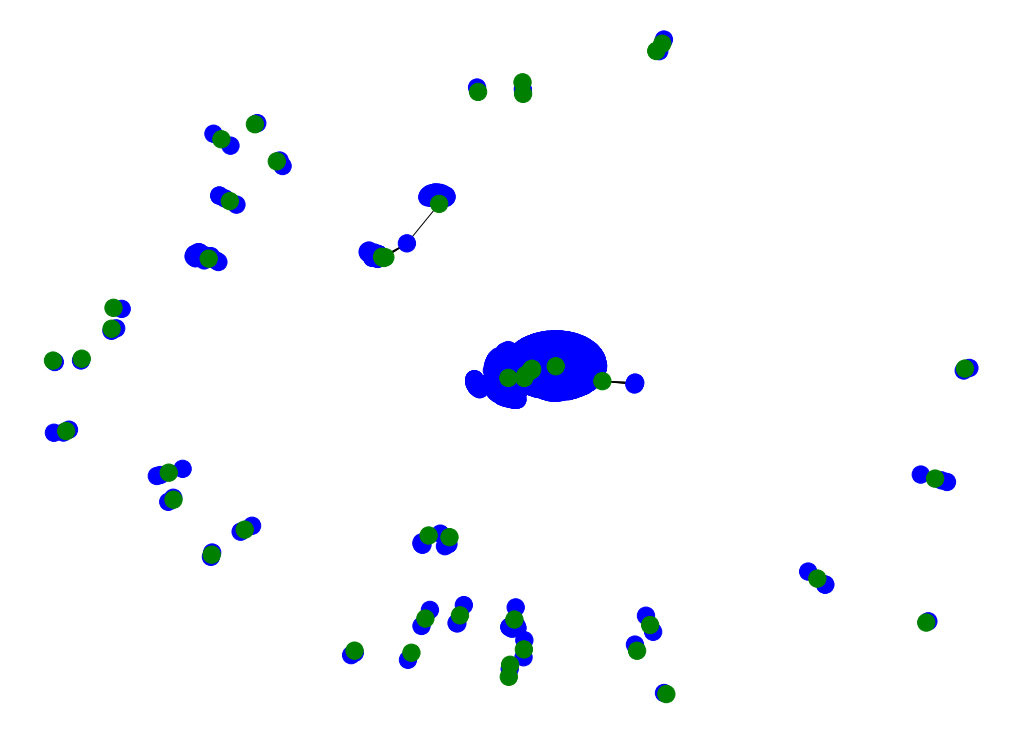

In [13]:
plt.figure(figsize=(14, 10))

color_map = []
for node in g:
    if node in a_nodes:
        color_map.append('blue')
    else: 
        color_map.append('green') 
nx.draw(g, node_color=color_map)

#### Circular Layout

In [ ]:
pos=nx.circular_layout(g)

![2mode](imgs/circular.png)

The above graph shows the structure of Papers-Authors network (Green are Papers and Blue are Authors).

### Weighted Projections/Clustering

Projection is the only way to analyse these networks. The process works by selecting one set of nodes, and linking two nodes if they are connected to the same node of the other set. 

Now we have constructed a graph object Let’s start by computing an affiliation network of the Authors

![2mode](imgs/projection.png)

### The Authors and Papers Network

The network has a connected component and a couple isolates. These are artifacts of when we wantonly chopped off a piece of a dataset for use as an example—and we can throw them away here just as well, by taking only the largest connected component:

In [14]:
# Let's Find the largest most connected graph - 200 as cut-off 

def connected_component_subgraphs(G): # the connected_component_subgraphs attribute is not availble after Networkx 2.4
    for c in nx.connected_components(G):
        yield G.subgraph(c)

big_subg = [i for i in connected_component_subgraphs(g) if len(i) > 200]
# Largest:
sg_largest = big_subg[0] # largest connected subgraph

In [15]:
# weighted_projections can be applied to this subgraph to separate the two components
Author_Names, Paper_Id = bi.sets(sg_largest)  # split into bipartites

In [16]:
# Returns a weighted projection of sg_largest onto one of its node sets (Journals).
p_proj_sg_largest = bi.weighted_projected_graph(sg_largest, Paper_Id)

In [24]:
# Returns a weighted projection of sg_largest onto one of its node sets (Author_Names).
a_proj_sg_largest = bi.weighted_projected_graph(sg_largest, Author_Names)
a_proj_sg_largest

The resulting network is significantly larger and will take a long time to draw; it will also look something like a hairball. It is clear that the network has a number of distinct clusters; we will now try to find them using the island method.

In [18]:
# Use the Island Method 
p = p_proj_sg_largest.edges(data=True) # return edge attribute dict in 3-tuple
a = a_proj_sg_largest.edges(data=True)

In [19]:
# Find weights in the projections that are greater than 1
print(len([i for i in a if i[2]['weight'] > 3]))
print(len([i for i in p if i[2]['weight'] > 3]))

612329
28


In [25]:
# With a min threshold of edge weight = 1, find the nodes with strong relationships within the sub-graphs. 

def tidy(g, weight):
    g_temp = nx.Graph()
    edge_bunch2 = [i for i in g.edges(data=True) if i[2]['weight'] > weight]    
    g_temp.add_edges_from(edge_bunch2)
    return g_temp

In [26]:
a_sg_island =  tidy(a_proj_sg_largest, 1)
p_sg_island = tidy(p_proj_sg_largest,1)

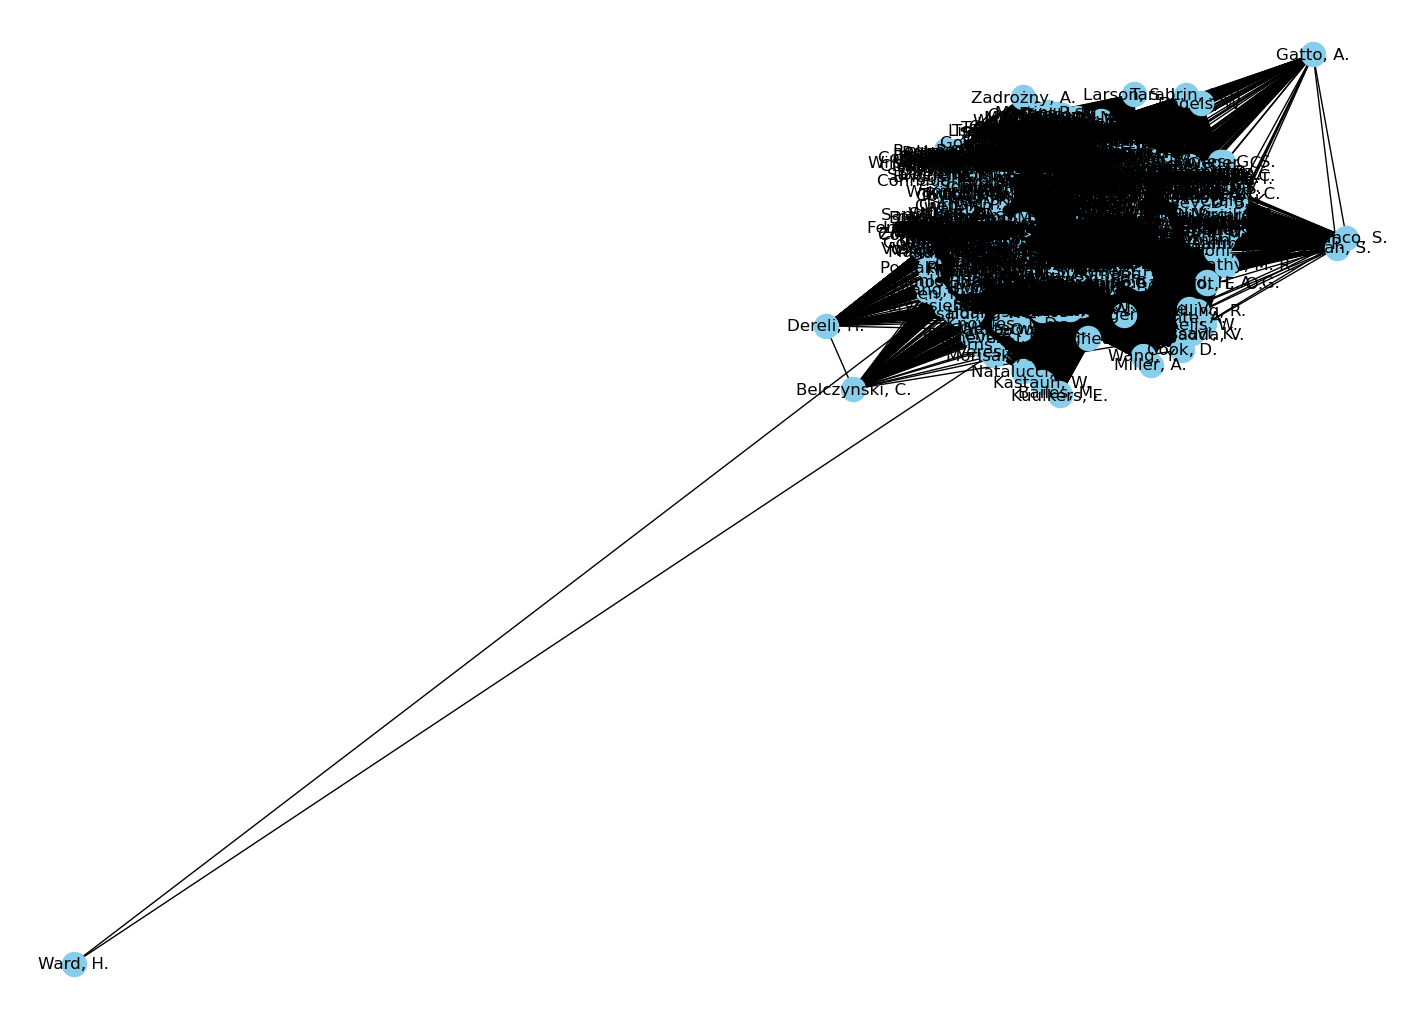

In [35]:
# Let's Graph the Authors sub-graphs found above.

plt.figure(figsize=(14, 10))
nx.draw(a_sg_island,node_color="skyblue", with_labels=True)

### ADS Visualization Tools

To get an at-a-glance overview of the Network we used the [ADS offers a network visualition tool](https://ui.adsabs.harvard.edu/search/p_=0&q=full%3A%22gravity%20waves%22&sort=date%20desc%2C%20bibcode%20desc/author-network), The author network detects groups of authors and connections between those groups within a set of results. We selected the top 200 most frequently appearing authors within our result set, The tool measures the frequency of collaboration between them, and displays color-coded groups of authors organized around a center point.

**1000 research paper**

![2mode](imgs/ads_graph.png)

**Link Overlay View 1000 research paper**

The overlay view help find authors who collaborate not only within their group but outside of it, check the “view link overlay” box and see which authors tend to collaborate with authors in other groups.

![2mode](imgs/ads_graph2.png)

### Node centrality

We now have two islands of the projected authors and journals. Examining the degree centrality will help reveal which nodes are the key to the networks.

In [36]:
# degree centrality of both island clusters
a_degree = nx.degree_centrality(a_sg_island)
p_degree = nx.degree_centrality(p_sg_island)
pd.DataFrame.from_dict(a_degree,orient='index').sort_values(0,ascending=False)


,0
"Bersanetti, D.",0.999216
"Calloni, E.",0.999216
"Chincarini, A.",0.999216
"Di Lieto, A.",0.999216
"Leonardi, M.",0.999216
...,...
"Dereli, H.",0.149020
"Belczynski, C.",0.149020
"Franco, S.",0.149020
"Shah, S.",0.149020


In [37]:
pd.DataFrame.from_dict(p_degree,orient='index').sort_values(0,ascending=False).head()

,0
1360434,1.000
1359534,1.000
1360978,1.000
2726744,0.875
11492508,0.875


Now that the islands are isolated, we can subset them into their largest connected subgraphs and do some basic plots.

In [22]:
# Let's examine the connected subgraphs

p_connected = [i for i in connected_component_subgraphs(p_proj_sg_largest) if len(i) > 1]
a_connected = [i for i in connected_component_subgraphs(a_proj_sg_largest) if len(i) > 1]

In [23]:
# Combining the graphs 
def merge_graph(connected_g):
    g = nx.Graph()
    for h in connected_g:
        g = nx.compose(g,h)
    return g

a_islands = merge_graph(a_connected)
p_islands = merge_graph(p_connected)


/home/taha/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


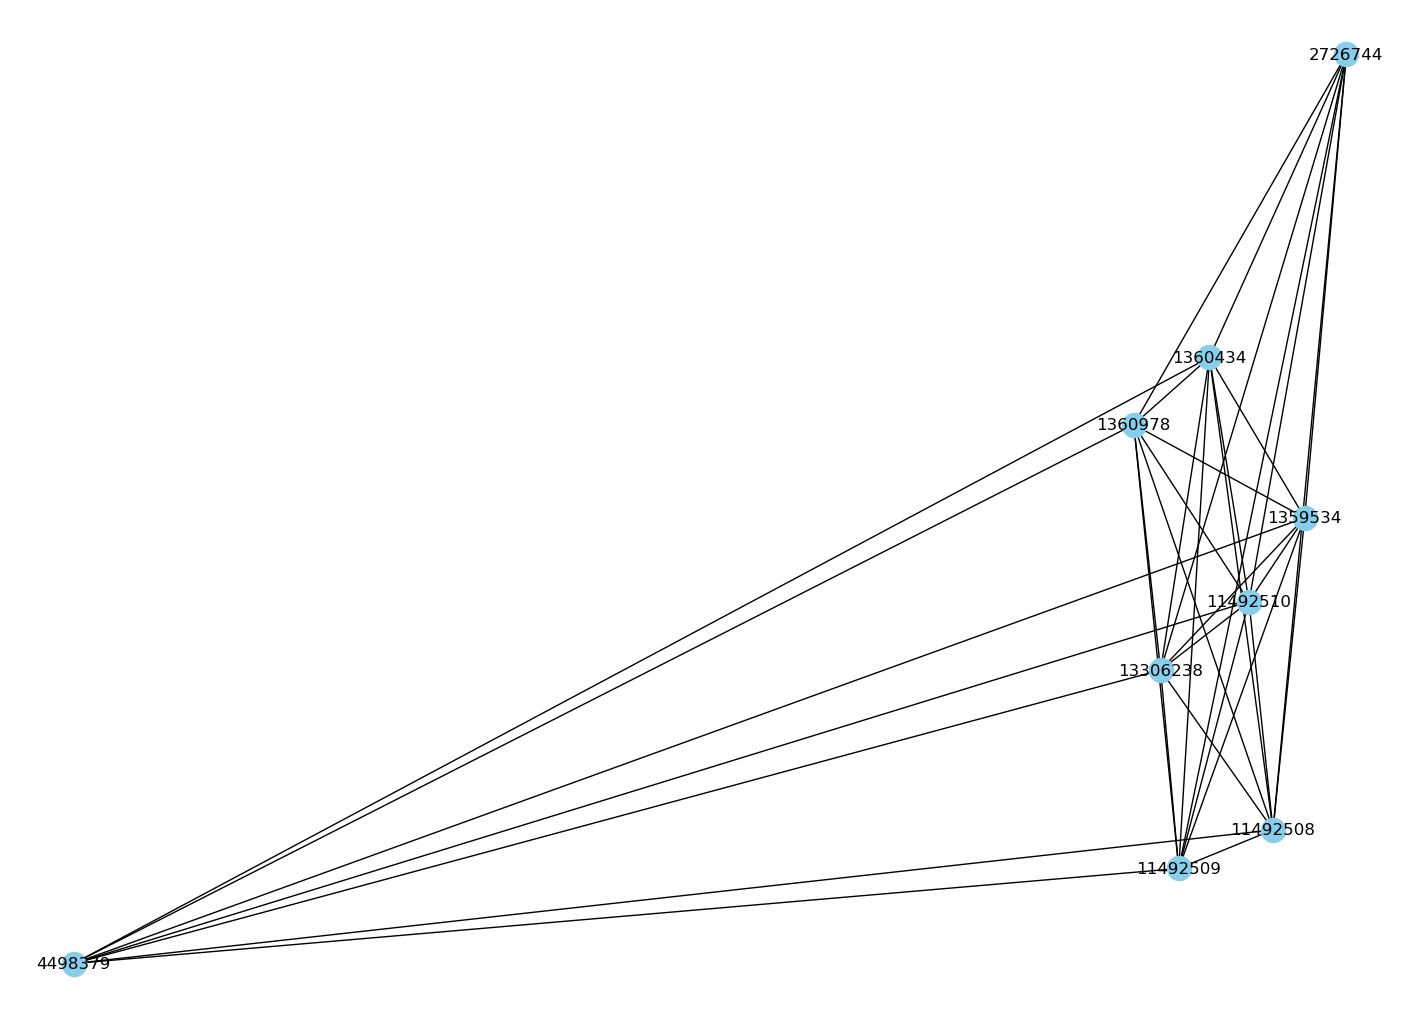

In [41]:
plt.figure(figsize=(14, 10))
nx.draw(p_islands,node_color="skyblue", with_labels=True)

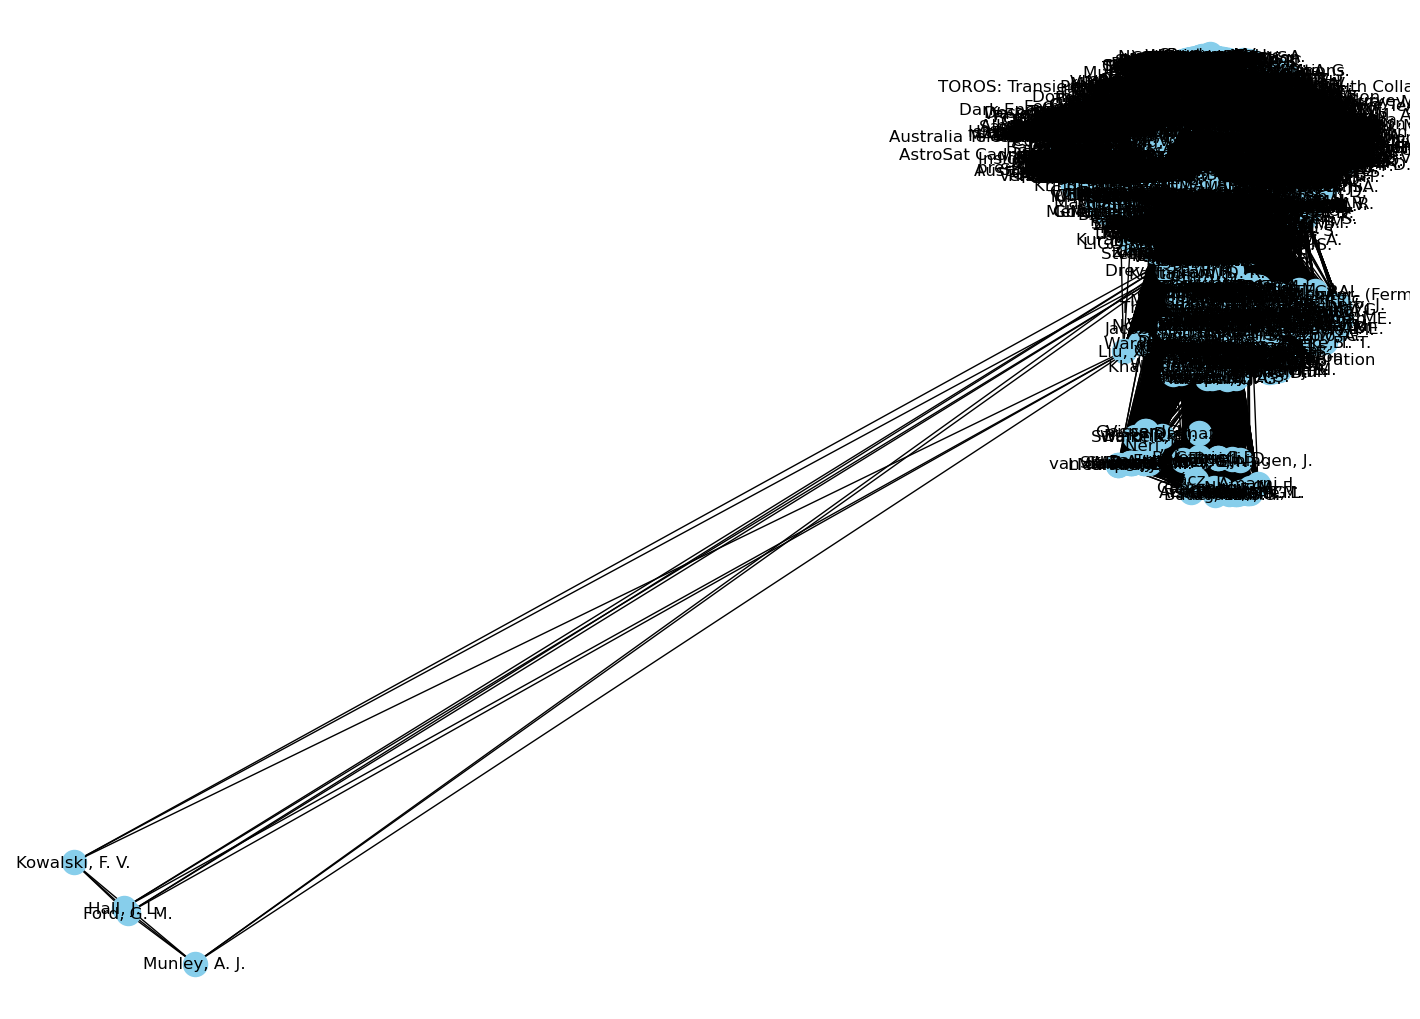

In [42]:
plt.figure(figsize=(14, 10))
nx.draw(a_islands, node_color="skyblue", with_labels=True)


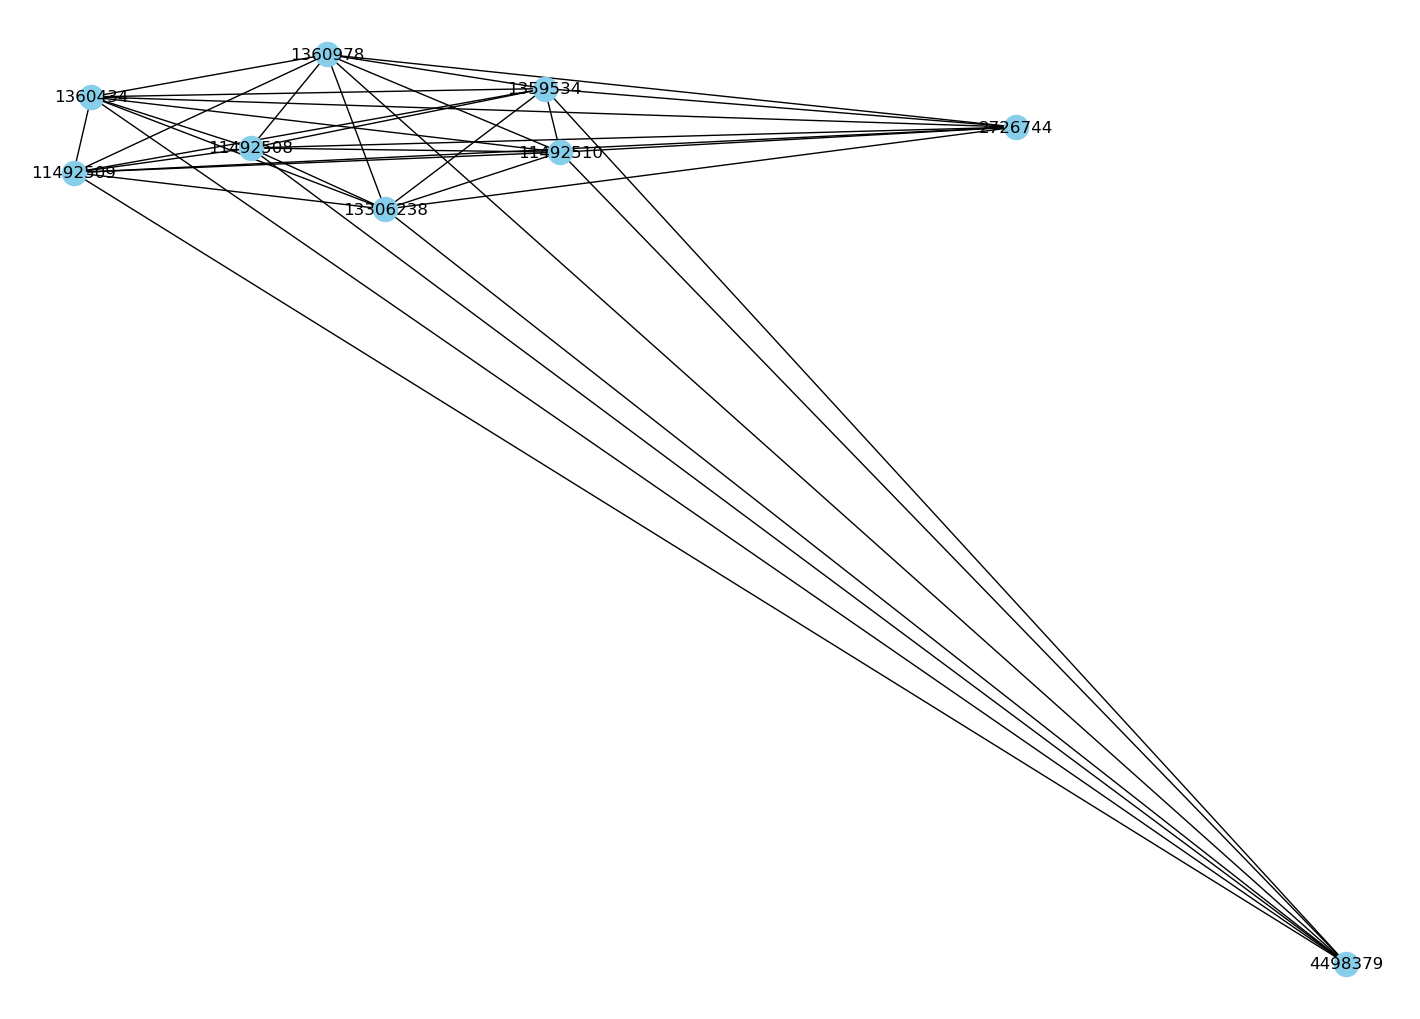

In [43]:
plt.figure(figsize=(14, 10))
nx.draw(p_islands, node_color="skyblue", with_labels=True)
pos=nx.circular_layout(p_islands)